# Hands-On Image Workshop: *Detecting Defects in Steel Strips Using Computer Vision* 

Within this hands-on workshop you will use a two different convolutional neural networks (CNNs) to classify different types of defects commonly found in steel strips. 

(And, if you're anything like the author you'll what on Earth defects in steel strips even look like!)

The steps which you will carry out are: 
1. Load the data
2. Perform some data exploration and visualisation
3. Build a couple of different CNNs and deploy these to Seldon
4. Add metadata to your newly created models
5. Create a drift detector and once again create this on Seldon

The model training code has been adapted from this blog post by `franky` on Medium: [Deep Learning, Computer Vision, and Automated Optical Inspection](https://towardsdatascience.com/deep-learning-computer-vision-and-automated-optical-inspection-774e8ca529d3)

Before you begin you will install/import the necessary dependencies to interact with Seldon Deplay and create your models and monitoring components.

In [ ]:
# Colab has a load of packages pre-loaded into the environment. 
# Installing the additional ones we require.
!pip install seldon_deploy_sdk
!pip install alibi_detect==0.6.1
!pip install dill
!pip install tensorflow==2.4.4

In [1]:
# General Packages
import os
import logging
import json
import numpy as np
import dill
import matplotlib.pyplot as plt
from functools import partial

# Model Building
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, GlobalAveragePooling2D, Flatten
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

# Explainer
from alibi.explainers import AnchorImage
from skimage import color
from skimage import morphology
from skimage import segmentation

# Outlier Detection
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

# Drift Detection
from alibi_detect.cd import MMDDrift
from alibi_detect.cd.tensorflow import preprocess_drift
from alibi_detect.utils.saving import save_detector, load_detector

# Seldon Deploy SDK
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi, ModelMetadataServiceApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

# Logging and Clearing Session
tf.keras.backend.clear_session()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2022-02-25 12:14:28.191185: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Once the Python dependencies have been installed and imported you can download the training and testing data. This will take approximately 2 minutes. 

In [ ]:
!wget https://storage.googleapis.com/tom-seldon-examples/workshops/manufactoring/data.zip
!mkdir data
!unzip -o 'data.zip' -d data

## Data Exploration

Loading the data into memory, as Keras `ImageDataGenerator` objects.

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255)
data_dir='data/train/images/'
train_ds = train_datagen.flow_from_directory(
    directory = data_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1440 images belonging to 6 classes.


In [3]:
val_datagen = ImageDataGenerator(rescale=1/255)
data_dir='data/validation/images/'
val_ds = train_datagen.flow_from_directory(
    directory = data_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 360 images belonging to 6 classes.


The dataset has 6 classes which you can view below by loading them into the `categories` dictionary. 

In [4]:
categories = (train_ds.class_indices)
categories = dict((v,k) for k,v in categories.items())
categories

{0: 'crazing',
 1: 'inclusion',
 2: 'patches',
 3: 'pitted_surface',
 4: 'rolled-in_scale',
 5: 'scratches'}

You can readily visualise a sample image to start to gain an understanding of the data you are working with.

In [ ]:
example_image = train_ds.next()[0][0]
print(example_image.shape)
plt.imshow(example_image[:,:])

As you can see above; the images you'll be working with are 3 things: 
1. Relatively small, only 224 x 224 pixels. 
2. In colour as they have 3 channels, but appear greyscale. 
3. Pretty boring to look at!

The image below shows a wider variety of the types of image which are available within the dataset. 

![steel photo examples](https://raw.githubusercontent.com/SeldonIO/deploy-workshops/master/manufacturing/assets/steel_images.jpeg "Title")

## Building the Models

Now that the data is loaded in and you have had the chance to explore and get to grips with it, you can turn your attention to model building. 

You will build and work on 2 separate models: 
1. Training from scratch a simple hand crafted architecture, using 3 convolutional layers. 
2. Fine tuning an InceptionV3 model which has been pre-trained on the ImageNet dataset. 

Once these models have been created you are going to deploy them alongside one another as a canary deployment via the Seldon Deploy SDK. 

Prior to beginning the building efforts create a simple callback which will stop training early if the validation accuracy breaks 90%. 

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.90 ):
            print("\nReached 90% validation accuracy so cancelling training!")
            self.model.stop_training = True 
            
callbacks = myCallback()

### Model 1: *Simple CNN*

Using Keras it is straightforward to define the CNN architecture, and this should be familiar if you have worked with CNNs before. 

Your neural network has three convolutional layers, each with 32 channels and a 3\*3 convolution. 

Looking at the model summary you can see the network has a total of approximately 11 million parameters. 

In [ ]:
simple_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), # First Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # Second Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # Third Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])

simple_cnn.summary()

Training the network is then straightforward using standard methods; `categorical_crossentropy` for the loss function, and `adam` as the optimisation technique. 

In [ ]:
simple_cnn.compile(loss = 'categorical_crossentropy',
                   optimizer = 'adam',
                   metrics = ['accuracy'])

simple_cnn_history = simple_cnn.fit(train_ds,
                                    batch_size = 32,
                                    epochs = 20,
                                    validation_data = val_ds,
                                    callbacks = [callbacks],
                                    verbose = 1,
                                    shuffle=True)

Watching a neural network train is the modern equivalent of watching paint dry, therefore to speed things up feel free to interrupt training and grab the pre-trained example available below. 

In [ ]:
!mkdir simple-cnn/
!gsutil cp -r gs://tom-seldon-examples/workshops/manufacturing/pretrained/simple-cnn/1 simple-cnn/

In [66]:
simple_cnn = load_model("simple-cnn/1")

Now that you have a trained neural network you can grab a test image and have your network generate a prediction!

In [ ]:
test_scratches = load_img('data/validation/images/scratches/scratches_241.jpg',
                          target_size=(224, 224, 3))

test_scratches = img_to_array(test_scratches)
test_scratches = test_scratches / 255
test_scratches  = test_scratches.reshape((-1,) + test_scratches.shape)

simple_preds = simple_cnn.predict(test_scratches)[0]

for v, i in enumerate(simple_preds):
    print(f"{categories[v]}: {i:.2f}")

As you can see the model is... **totally** wrong!

Even worse than that, it's confidentally wrong- being fully convinced that the test scratch image has in fact been rolled in scale. 

The checkpointed model you're relying on here only acheived a validation accuracy of around 78% so this might be expected.

Let's see if this can be improved upon by using the InceptionV3 architecture.

### Model 2: *InceptionV3*

For your second model you will make use of the pre-trained InceptionV3 architecture. InceptionV3 is a CNN built for object classification by [researchers at Google in 2015](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf). Back then it held the state of the art crown for a while, however more recently has been overtaken by more modern EfficientNet or Transformer architectures. 

It has been selected here because it is reasonable to train on a CPU, it gets great results and Keras has a built-in version of the model making it super easy to get going with!

The key information to note around how you are preparing the InceptionV3 model is that when loaded you do not include the final layers (`include_top=False`). 

Three extra layers are then built on top of the InceptionV3 model; a pooling layer (`GlobalAveragePooling2D`), and two fully connected layers (`Dense`).

These new layers are glued onto InceptionV3 and compiled using the same evaluation methods as you used with the `simple-cnn`. 

In [ ]:
# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 6
conv_size = 32

# parameters for training
batch_size = 32
num_epochs = 20

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
custom_output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
inception = Model(inputs=InceptionV3_model.input, outputs=custom_output)
        
# compile the model
inception.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

inception.summary()

In [ ]:
inception_history = inception.fit(train_ds,
                                  batch_size=32,
                                  epochs=20,
                                  validation_data=val_ds,
                                  callbacks=[callbacks],
                                  verbose=1, 
                                  shuffle=True)

Watching an even larger neural network train is simply like watching an even larger wall dry, so once more you can take advantage of a pre-trained artefact.

In [68]:
!mkdir inception/
!gsutil cp -r gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1 inception/

mkdir: inception/: File exists
Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1/saved_model.pb...
Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1/variables/variables.data-00000-of-00001...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1/variables/variables.index...
\ [3 files][268.9 MiB/268.9 MiB]   19.2 MiB/s                                   
Operation completed over 3 objects/268.9 MiB.                                    


In [5]:
inception = load_model("inception/1")

Similarly to the `simple_cnn` built earlier you can test your `inception` model on the same `test_scratch` image to get an anecdotal feel for how it's going to perform. 

In [23]:
inception_preds = inception.predict(test_scratches)[0]

for v, i in enumerate(inception_preds):
    print(f"{categories[v]}: {i:.2f}")

crazing: 0.00
inclusion: 0.00
patches: 0.00
pitted_surface: 0.00
rolled-in_scale: 0.00
scratches: 1.00


In [ ]:
inception_preds

**Hurrah!** 

This result looks better, and you can also take some reassurance that this pre-trained `inception` model achieved a much more respectable validation accuracy of 94%. 

Time to start thinking about how you might want to serve your newly created models. 

## Deploying Your Models

Now that you have trained and saved your model artefacts you can begin consider how to deploy them to Seldon. 

This process will involve uploading the relevant artefacts to blob storage, where they can be pulled from at deployment time. 

You will then configure connection to a Seldon Deploy cluster, and leverage the pre-built Tensorflow Serving runtime to create your deployment. 

---

To begin with, you will push the `simple-cnn` and `inception` models to a Google storage bucket. It's worth noting that Seldon Deploy reads from a wide range of storage back ends and so all of the popular blob storage tools are covered as well.

You will create a unique folder with your name. Uncomment the commands and replace "YOUR NAME" with your name.

Tensorflow Serving, similarly to Nvidia's Triton, when pulling model artefacts from a directory expects that there are sub-directories representing the version of the model artefacts. TF Serving can then be configured to serve a given model version. 

Given that you only have the single version for both of your models currently you will simply save version 1.

In [ ]:
# !gsutil cp -r simple-cnn/1/ gs://tom-seldon-examples/workshops/manufacturing/<YOUR NAME>/simple-cnn/
# !gsutil cp -r inception/1/ gs://tom-seldon-examples/workshops/manufacturing/<YOUR NAME>/inception/

You can now deploy your models to the dedicated Seldon Deploy cluster which has been configured for this workshop. To do so you will interact with the Seldon Deploy SDK and deploy your model using that.

First, setting up the configuration and authentication required to access the cluster. 

In [ ]:
SD_IP = "34.147.53.165"
config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now you have configured the IP correctly as well as setup the authentication function you can describe the deployment you would like to create. 

As you have uncovered earlier the `simple-cnn` is not great, and the `inception` model improves dramatically on that performance. This has been demonstrated on your validation data, but neither model has seen any live data. 

In this scenario you may wish to test both models on the live data, to achieve this Seldon Deploy provides you with two options; a shadow deployment or a canary deployment. 

These techniques are usually applied to the rollout or upgrade of a new model version. A shadow deployment deploys two models behind a single endpoint, both of the models receive 100% of the traffic- there is no split. However, only one of the models' responses are returned to users- usually the original model you are upgrading. The others responses (new version) are simply logged to Elasticsearch where you can see how it responded compared to the original model. This allows you to roll out new versions of a model, test them on live data, without the risk of poor performance impacting user experience. 

The other option is a canary deployment; this involves a traffic split between the two models behind a single endpoint. The percentage split is determined by you, and allows you to control how much of the live data goes to each of the models. New versions of models will typically be sent a smaller percentage of traffic (10% or 20%) to validate they are behaving as expected before they are rolled out more fully.

In this example you will create a canary deployment with a 70/30 split between the `inception` model and `simple-cnn` respectively. 

---

The [Seldon Deploy SDK](https://github.com/SeldonIO/seldon-deploy-sdk) offers two approaches to creating deployments: 
1. Working directly with dictionaries, which are equivalent to the underlying Kubernetes manifests. 
2. Using the higher level Python classes as abstractions. 

In this example you will use the more direct approach of working with the dictionaries. While this requires some more configuration it does create the opportunity to make reusable templates which are custom to your needs and can be readily shared and understood by others. 

You will start by defining some variables for the deployment which will be passed to the `mldeployment` manifest object in the following cell. 

In [ ]:
YOUR_NAME = <YOUR NAME>
DEPLOYMENT_NAME = f"{YOUR_NAME}-test"
NAMESPACE = "default"

MODEL_NAME = "inception"
MODEL_LOCATION = f"gs://tom-seldon-examples/workshops/manufacturing/{YOUR_NAME}/{MODEL_NAME}/"

CANARY_NAME = "simple-cnn"
CANARY_LOCATION = f"gs://tom-seldon-examples/workshops/manufacturing/{YOUR_NAME}/{CANARY_NAME}/"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

In [ ]:
mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "protocol": "seldon",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{MODEL_NAME}",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 70,
                "graph": {
                    "implementation": "TENSORFLOW_SERVER",
                    "modelUri": MODEL_LOCATION,
                    "name": f"{MODEL_NAME}",
                    "logger": {
                        "mode": "all"
                    }
                }
            },
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{CANARY_NAME}",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "canary",
                "replicas": 1,
                "annotations":{
                    "seldon.io/canary":"true"
                },
                "traffic": 30,
                "graph": {
                    "implementation": "TENSORFLOW_SERVER",
                    "modelUri": CANARY_LOCATION,
                    "name": f"{CANARY_NAME}",
                    "logger": {
                        "mode": "all"
                    }
                    }
                }
        ]
    }
}

Once you have specified your `mldeployment` JSON it is a simple API call to create your deployment. 

In [ ]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

You can now test your model endpoint in the UI. To access the workshop cluster use the following details: 
* Seldon Deploy URL: http://34.147.53.165/seldon-deploy/
* Username: admin@seldon.io
* Password: 12341234

Once you have seen your deployment creating you can save a sample image using the `test-scratches` array you worked with earlier. 

This `test-scratches.json` can be uploaded directly to the UI to test your model endpoint when it is available!

In [ ]:
seldon_sample = {
  "data": {
    "names": [
    ],
    "ndarray": test_scratches.tolist()
  }
}

with open('test-scratches.json', 'w', encoding='utf-8') as f:
    json.dump(seldon_sample, f, ensure_ascii=False, indent=1)

# Adding Model Metadata

You have now created 2 new models within a single deployment. Both of these models have been automatically added to the model catalog. The model catalog acts as a centralised repository for metadata associated with models. Models can be easily deployed directly from the catalog, while metadata acts to speed knowledge transfer between teams and to track models across tools.

You will now add some metadata to your InceptionV3 model describing the validation accuracy you managed to achieve, and who authored the model- so you can brag to your colleagues!

In [ ]:
model_catalog_metadata = {
      "URI": MODEL_LOCATION,
      "name": "InceptionV3",
      "version": "v1.0",
      "artifactType": "TENSORFLOW",
      "taskType": "defect classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "creationTime": "2022-02-15T15:26:26.630592Z",
      "project": "default"
    }

In [ ]:
api_instance = ModelMetadataServiceApi(auth())
api_response = api_instance.model_metadata_service_update_model_metadata(model_catalog_metadata)

Listing the metadata for your newly updated model:

In [ ]:
api_response = api_instance.model_metadata_service_list_model_metadata(uri=MODEL_LOCATION)
api_response

# Drift Detection

The final stage of the deployment process is going to be adding the advanced monitoring capabilities afforded by a drift detector. 

In this example you will use Alibi Detect to train a custom drift detector which can flag when the underlying input data distribution has shifted. This can inform decisions about re-training or prompt deeper investigation into data/model behaviours. 

Seldon Deploy also allows you to setup alerts when drift is detected. 

---

In this example you will use the Maximum Mean Discrepancy method. Covariate or input drift detection relies on creating a distance measure between two distributions; a reference distribution and a new distribution. The MMD drift detector is no different; the mean embeddings of your features are used to generate the distributions and then the distance between them is measured. The training data is used to calculate the reference distribution, while the new distribution comes from your inference data.  

More technically, a reproducing kernel Hilbert space is used to generate the mean embeddings, by mapping the highly complex feature space within which most machine learning models operate to a linear Euclidean space. A radial basis function kernel is then used to measure the distance between the two embeddings, and the signifiance of the drift is calculated as a p-value using permutation/resampling tests. More details can be found [here](https://docs.seldon.io/projects/alibi-detect/en/v0.6.1/methods/mmddrift.html).

Before you dive into creating your own drift detector, you need to generate a reference dataset. In this case you use 5 batches of the training data set, resulting in 160 images. This has been picked for convenience and speed of training in the workshop, and if this was a production case you would likely want to use the entirety of the training set, or a statistically significant segment.

Now, creating your reference set. 

In [ ]:
train_ds.reset()

drift_ref = train_ds.next()[0]

for i in range(4):
    drift_ref = np.concatenate((drift_ref, train_ds.next()[0]))

drift_ref.shape

Due to the high dimensionality of image data you will need perform a pre-processing step to make it computationally feasible to detect drift on incoming batches of images. 

A great option for this is to use an simple encoding neural network. This will squish images from their original shape of `(224, 224, 3)` to a vector of `32`. From there we can feed the vectors to the drift detector and calculate drift values. 

This is then used to a generate a `preprocess_fn` which will be fed to your MMD drift detector to convert your images ahead of time. 

In [ ]:
# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(224, 224, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=160)

Next you can initialise the drift detector; this is as simple as a single line API call specifying the:
* Reference data
* Computational backend
* The p-value below which drift is considered to have occurred
* Your preprocessing function
* The number of permutations taken to calculate the p-value

In [ ]:
# initialise drift detector
cd = MMDDrift(drift_ref, backend='tensorflow', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

Once your shiny new drift detector has trained you can test it on a new batch of data!

In [ ]:
new_batch = train_ds.next()[0]
preds = cd.predict(new_batch, return_p_val=True, return_distance=True)
preds

Finally, you can save the drift detector and upload it to Google storage for deployment. 

In [ ]:
filepath = 'defect-drift'
save_detector(cd, filepath)

In [ ]:
!gsutil cp -r defect-drift gs://tom-seldon-examples/workshops/manufacturing/drift/tom-farrand/defect-drift

In [ ]:
f"gs://tom-seldon-examples/manufacturing/workshops/drift/<YOUR NAME>/{filepath}"

# Explainer

In [6]:
predict_fn = lambda x: inception.predict(x)

In [26]:
def slicSegmentation(image):
    slic = segmentation.slic(image, n_segments=15, start_label=1)
    return slic


In [7]:
example_image = train_ds.next()
image_shape = example_image[0][0].shape
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

In [27]:
example_image = train_ds.next()
image_shape = example_image[0][0].shape
explainer = AnchorImage(predict_fn, image_shape,segmentation_fn=slicSegmentation)

In [8]:
example_image = load_img('data/validation/images/inclusion/inclusion_285.jpg',
                          target_size=(224, 224, 3))
# print(example_image[1][0])
# print(categories)
example_image = img_to_array(example_image)
print(example_image.shape)
# print("Labeled Values")
# for v, i in enumerate(example_image[1][0]):
#     print(f"{categories[v]}: {i:.2f}")

# example_image = example_image[0][0]

# print(example_image.shape)
# print("Predicted Values")
# plt.imshow(example_image[:,:]);

example_image = example_image / 255
example_image  = example_image.reshape((-1,) + example_image.shape)

for v, i in enumerate(inception.predict(example_image)[0]):
    print(f"{categories[v]}: {i:.2f}")

example_image.shape

(224, 224, 3)
crazing: 0.00
inclusion: 1.00
patches: 0.00
pitted_surface: 0.00
rolled-in_scale: 0.00
scratches: 0.00


(1, 224, 224, 3)

In [74]:
seldon_sample = {
  "data": {
    "names": [
    ],
    "ndarray": example_image.tolist()
  }
}

with open('test-patches-2.json', 'w', encoding='utf-8') as f:
    json.dump(seldon_sample, f, ensure_ascii=False, indent=1)

### Explain a Test Image

In [14]:
def slicMask(image):
    # Compute a mask
    lum = color.rgb2gray(image)
    mask = morphology.remove_small_holes(
        morphology.remove_small_objects(
            lum < 0.7, 500),
        500)

    mask = morphology.opening(mask, morphology.disk(3))
    return mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


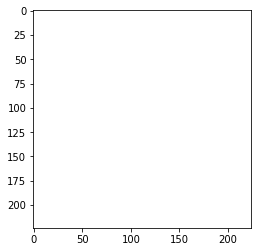

In [15]:
example_image = load_img('data/validation/images/inclusion/inclusion_285.jpg',
                          target_size=(224, 224, 3))
example_image = img_to_array(example_image)
print(example_image.shape)
plt.imshow(example_image);
explanation = explainer.explain(example_image, threshold=.90 , p_sample=.5, seed=0, verbose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/josh/opt/anaconda3/envs/manufactoring-workshop/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Text(0.5, 1.0, "The Boxes that don't look like boxes")

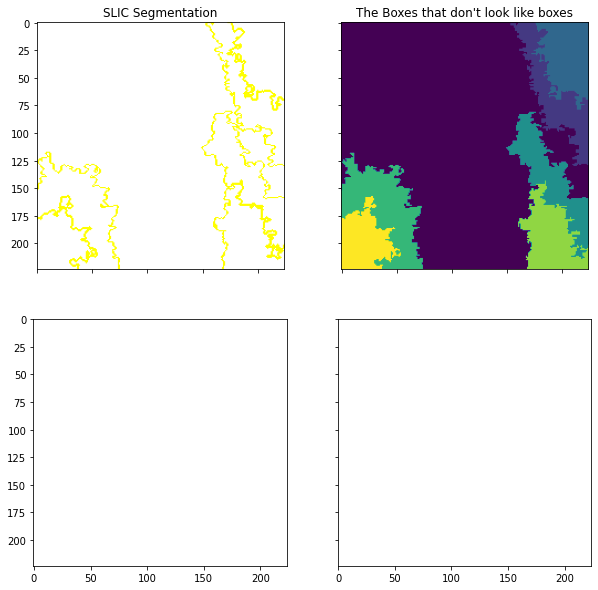

In [16]:
# Add Mask for graph using Sciimage 
example_image_mask = slicMask(example_image)

fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()


ax1.imshow(segmentation.mark_boundaries(example_image, explanation.segments))
ax1.contour(example_image_mask, colors='red', linewidths=1)
ax1.set_title('SLIC Segmentation')

ax2.imshow(explanation.segments)
# ax1.contour(example_image_mask, colors='red', linewidths=1)
ax2.set_title('The Boxes that don\'t look like boxes')


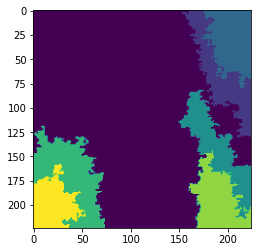

In [10]:
plt.imshow(explanation.segments)

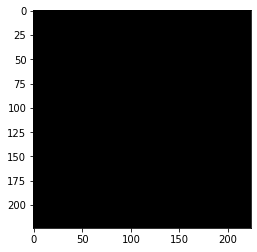

In [97]:
plt.imshow(explanation.anchor[:,:])

In [98]:
not explanation.anchor.any()

True

### Scratch 

In [ ]:
example_image_slic_segments = slicSegmentation(example_image)
example_image_mask = slicMask(example_image)

fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()


ax1.imshow(segmentation.mark_boundaries(example_image, example_image_slic_segments))
ax1.contour(example_image_mask, colors='red', linewidths=1)
ax1.set_title('SLIC Segmentation')

ax2.imshow(example_image_slic_segments)
# ax1.contour(example_image_mask, colors='red', linewidths=1)
ax2.set_title('The Boxes that don\'t look like boxes')


In [ ]:
explanation.anchor

### Save and Upload Explainer Artifact

In [31]:
dill.dump(explainer, open( "explainer.dill", "wb")) 

In [33]:
!gsutil cp explainer.dill gs://tom-seldon-examples/workshops/manufacturing/pretrained/explainer/explainer.dill 

Copying file://explainer.dill [Content-Type=application/octet-stream]...
/ [1 files][  1.1 KiB/  1.1 KiB]                                                
Operation completed over 1 objects/1.1 KiB.                                      


# Outlier Detection

In [ ]:
load_outlier_detector = False

### AE

In [ ]:
from alibi_detect.od import OutlierAE


filepath = 'outlier'  # change to (absolute) directory where model is downloaded
detector_type = 'outlier'
dataset = 'test'
detector_name = 'OutlierAE'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    encoding_dim = 1024

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
          Flatten(),
          Dense(encoding_dim,)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(encoding_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])

    # initialize outlier detector
    od = OutlierAE(threshold=.015,  # threshold for outlier score
                    encoder_net=encoder_net,  # can also pass AE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    )
    # train
    od.fit(train_ds,
           epochs=50,
           verbose=True)

    # save the trained outlier detector
    save_detector(od, filepath)

### VAE

In [ ]:
filepath = 'outlier'  # change to directory where model is downloaded
detector_type = 'outlier'
dataset = 'test'
detector_name = 'OutlierVAE'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    latent_dim = 1024
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(224, 224, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])
    
    # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=2)
    # train
    od.fit(train_ds, 
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=2,
           verbose=True)
    
    # save the trained outlier detector
    save_detector(od, filepath)

## Check quality VAE model

In [ ]:
example_image = train_ds.next()
example_image = example_image[0][0]
print(example_image.shape)
plt.imshow(example_image[:,:]);

example_image = example_image / 255
example_image  = example_image.reshape((-1,) + test_image.shape)

print(type(example_image))
print(example_image.shape)

y_pred = np.argmax(model.predict(test_image), axis=-1)
print(y_pred)
classname = y_pred[0]
print("Class: ", categories[classname])

In [ ]:
example_image = val_ds.next()
# label = --> grab the real label
example_image_np = example_image[0][0]

In [ ]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

# Input data
img = example_image_np
print(type(img))
# Compute a mask
lum = color.rgb2gray(img)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.7, 500),
    500)

mask = morphology.opening(mask, morphology.disk(3))

# SLIC result
slic = segmentation.slic(img, n_segments=15, start_label=1)

# maskSLIC result
m_slic = segmentation.slic(img, n_segments=100, mask=mask, start_label=1)

# Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(img, slic))
ax3.contour(mask, colors='red', linewidths=1)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(img, m_slic))
ax4.contour(mask, colors='red', linewidths=1)
ax4.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()
 
plt.tight_layout()
plt.show()

In [ ]:
# SLIC result
segmentation.slic(img, n_segments=15, start_label=1).shape